In [59]:
import pandas as pd
import os
from datetime import datetime as dt

from sklearn.metrics import roc_auc_score, roc_curve, average_precision_score, precision_recall_curve, auc
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

import pycountry as pc

import warnings
warnings.filterwarnings('ignore')

In [60]:
# classification targets
target_conf = 'armedconf'
target_escl = 'escalation'

# regression target
target_regr = 'deaths_all_pc'

# many features are made per-country
unit_of_analyis = 'isocode'

# start and end of test set
start_month_year = dt(2018, 1, 1)
end_month_year = dt(2023, 3, 1)

# time horizons forecase for
fwds = [1,3,6]

# target groupings
clsf_targets = [target_conf, target_escl]
regr_targets = [target_regr]

all_targets = clsf_targets + regr_targets

# algorithms used
algos = ['rf', 'xgb']

## Import predictions and join with true values

In [61]:
path = os.getcwd()
parent_path = os.path.abspath(os.path.join(path, os.pardir))

### Re-create targets

Generated from all data, so need to drop training data.

In [62]:
df_og = pd.read_csv(os.path.abspath(parent_path + '/data/preprocessed_df.csv'))

df_og['month_year'] = pd.to_datetime(df_og['month_year'])

print(df_og.shape)
print(df_og.month_year.min(), df_og.month_year.max())
df_og.head()

(54915, 88)
2000-01-01 00:00:00 2023-03-01 00:00:00


,isocode,month_year,month,year,Country Name,deaths_all_pc,armedconf,escalation,past6,past12,...,isocode_4,isocode_5,isocode_6,isocode_7,f3_target_escl,f6_target_escl,f3_target_clsf,f6_target_clsf,f3_target_regr,f6_target_regr
0,AFG,2000-01-01,1,2000,Afghanistan,0.276314,True,0,0.276314,0.276314,...,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN
1,AFG,2000-02-01,2,2000,Afghanistan,0.777290,True,1,1.053604,1.053604,...,0,0,0,1,1.0,1.0,1.0,1.0,1.701424,1.600231
2,AFG,2000-03-01,3,2000,Afghanistan,1.620053,True,0,2.673657,2.673657,...,0,0,0,1,0.0,1.0,1.0,1.0,1.581843,2.404725
3,AFG,2000-04-01,4,2000,Afghanistan,2.706927,True,0,5.380585,5.380585,...,0,0,0,1,0.0,1.0,1.0,1.0,1.160851,3.083456
4,AFG,2000-05-01,5,2000,Afghanistan,0.418548,True,0,5.799133,5.799133,...,0,0,0,1,1.0,1.0,1.0,1.0,1.499038,2.822271


In [63]:
def make_target_clsf(df: pd.DataFrame, shifter: int, target: str):

    # loop through each period and generate the shift variables (name doesn't matter, just interim columns to take max)
    for i in range(1, shifter+1):
        col_name = f'{target}{i}'
        df[col_name] = df.groupby(unit_of_analyis)[str(target)].shift(-i)

    # take the maximum for t periods forward and create the new variable & drop the shift variables
    df[f'{target}_f{shifter}'] = df[[f'{target}{i}' for i in range(1, shifter+1)]].max(axis=1, skipna=False)
    df = df.drop(columns=[f'{target}{i}' for i in range(1, shifter+1)])
    
    return(df)


def make_target_regr(df: pd.DataFrame, shifter: int, target: str): 

    # loop through each period and generate the temporary shift variables
    for i in range(1, shifter+1):
        col_name = f'{target}{i}'
        df[col_name] = df.groupby(unit_of_analyis)[str(target)].shift(-i)

    # take the mean for t periods forward and create the new variable &
    df[f'{target}_f{shifter}'] = df[[f'{target}{i}' for i in range(1, shifter+1)]].mean(axis=1, skipna=False)

    # 
    df = df.drop(columns=[f'{target}{i}' for i in range(1, shifter+1)])
    
    return(df)

In [64]:
# demonstrating the make_target functions
df_targets = df_og.copy()

# generate targets
for fwd in fwds:
    for target in clsf_targets:
        df_targets = make_target_clsf(df_targets, fwd, target)
    
    for target in regr_targets:
        df_targets = make_target_regr(df_targets, fwd, target)

# check it worked
fwd = 3
df_targets.loc[df_targets['isocode'] == 'BFA', ['isocode', 'Country Name', 'month_year',  'armedconf',  f'{target_escl}_f{fwd}', f'{target_conf}_f{fwd}','deaths_all_pc', f'{target_regr}_f{fwd}']][-8:]

,isocode,Country Name,month_year,armedconf,escalation_f3,armedconf_f3,deaths_all_pc,deaths_all_pc_f3
43378,BFA,Burkina Faso,2022-08-01,True,0.0,1.0,1.475068,0.754125
43379,BFA,Burkina Faso,2022-09-01,True,0.0,1.0,0.868751,0.758649
43380,BFA,Burkina Faso,2022-10-01,True,0.0,1.0,0.475098,0.600283
43381,BFA,Burkina Faso,2022-11-01,True,1.0,1.0,0.918524,1.010527
43382,BFA,Burkina Faso,2022-12-01,True,1.0,1.0,0.882326,1.561038
43383,BFA,Burkina Faso,2023-01-01,False,NaN,NaN,0.000000,NaN
43384,BFA,Burkina Faso,2023-02-01,True,NaN,NaN,2.149255,NaN
43385,BFA,Burkina Faso,2023-03-01,True,NaN,NaN,2.533858,NaN


In [65]:
df_targets = df_targets.loc[df_targets['month_year'] >= start_month_year]

print(df_targets.shape)
df_targets.columns

(12411, 97)


Index(['isocode', 'month_year', 'month', 'year', 'Country Name',
       'deaths_all_pc', 'armedconf', 'escalation', 'past6', 'past12', 'past60',
       'past120', 'armedconf_since', 'deaths_stock', 'share_events_1',
       'share_events_2', 'share_events_3', 'share_events_4', 'share_events_5',
       'share_events_6', 'share_events_7', 'share_events_8', 'share_events_9',
       'share_events_10', 'share_events_11', 'share_events_12',
       'share_events_13', 'share_events_14', 'share_events_15',
       'share_events_16', 'share_events_17', 'share_events_18',
       'share_events_19', 'share_events_20', 'share_events_gov',
       'share_events_opp', 'norm_total_events', 'event_share_1_stock',
       'event_share_2_stock', 'event_share_3_stock', 'event_share_4_stock',
       'event_share_5_stock', 'event_share_6_stock', 'event_share_7_stock',
       'event_share_8_stock', 'event_share_9_stock', 'event_share_10_stock',
       'event_share_11_stock', 'event_share_12_stock', 'event_share_1

### Import predictions

All are joined into a single data frame.

In [66]:
df_preds = pd.read_csv(os.path.abspath(path + f'/tree_based_pred/Final/predictions_rf_f1_escalation.csv'))
df_preds = df_preds[['isocode', 'month_year']]
df_preds['month_year'] = pd.to_datetime(df_preds['month_year'])

print(df_preds.shape, df_targets.shape)
print(df_preds.month_year.min(), df_preds.month_year.max())
print(df_targets.month_year.min(), df_targets.month_year.max())

df_preds.head()

(12411, 2) (12411, 97)
2018-01-01 00:00:00 2023-03-01 00:00:00
2018-01-01 00:00:00 2023-03-01 00:00:00


,isocode,month_year
0,AFG,2018-01-01
1,AGO,2018-01-01
2,ALB,2018-01-01
3,ARE,2018-01-01
4,ARG,2018-01-01


In [67]:
for algo in algos:
    for fwd in fwds:
        for target in all_targets: # all_targets

            df_temp = pd.read_csv(os.path.abspath(path + f'/tree_based_pred/Final/predictions_{algo}_f{fwd}_{target}.csv'))
            df_temp.drop(columns=['Unnamed: 0'], inplace=True)
            
            df_temp['month_year'] = pd.to_datetime(df_temp['month_year'], format='%Y-%m-%d')
            df_temp.sort_values(by=['month_year', 'isocode'], inplace=True)
            
            print(df_temp.shape, df_temp.month_year.min(), df_temp.month_year.max())
            
            #print(df_temp.columns )
            #df_preds = pd.concat([df_preds, df_temp], axis=1)

            df_preds = df_preds.merge(df_temp, how='left', on=['isocode', 'month_year'])

(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00
(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00
(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00
(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00
(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00
(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00
(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00
(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00
(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00
(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00
(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00
(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00
(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00
(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00
(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00
(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00
(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00
(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00


In [68]:
df_preds = df_preds.loc[:,~df_preds.T.duplicated(keep='first')]

print(df_preds.shape)
#df_preds.columns
df_preds.head(2)

(12411, 56)


,isocode,month_year,pred_armedconf_rf_f1_all,pred_armedconf_rf_f1_hs,pred_armedconf_rf_f1_tx,pred_escalation_rf_f1_all,pred_escalation_rf_f1_hs,pred_escalation_rf_f1_tx,pred_deaths_all_pc_rf_f1_all,pred_deaths_all_pc_rf_f1_hs,...,pred_deaths_all_pc_xgb_f3_tx,pred_armedconf_xgb_f6_all,pred_armedconf_xgb_f6_hs,pred_armedconf_xgb_f6_tx,pred_escalation_xgb_f6_all,pred_escalation_xgb_f6_hs,pred_escalation_xgb_f6_tx,pred_deaths_all_pc_xgb_f6_all,pred_deaths_all_pc_xgb_f6_hs,pred_deaths_all_pc_xgb_f6_tx
0,AFG,2018-01-01,0.988908,0.991190,0.958227,0.405951,0.114284,0.763412,11.127582,11.223889,...,3.572988,1.000000,0.999882,1.000000,0.989187,0.997928,0.999490,2.151273,2.929380,2.874567
1,AGO,2018-01-01,0.210516,0.235263,0.351255,0.608128,0.714963,0.314381,0.009906,0.008070,...,0.153685,0.017353,0.001365,0.025607,0.998660,0.984795,0.991863,0.192119,0.187882,0.188585


In [69]:
print('armed conflicts:', df_og[target_conf].sum())
print('perc of observ.:', df_og[target_conf].sum()/len(df_og)*100)

## with old preprocessing
# armed conflicts: 7144
# perc of observ.: 8.94397496087637

armed conflicts: 4594
perc of observ.: 8.36565601383957


### Join targets & predictions

Single data frame from which to generate metrics.

In [70]:
df_targ = df_targets.copy()
df_pred = df_preds.copy()

In [71]:
# ensure same order or sorting
df_targ.sort_values(by=['month_year', 'isocode'], inplace=True)
df_targ.reset_index(drop=True, inplace=True)
df_targ['month_year'] = pd.to_datetime(df_targ['month_year'], format='%Y-%m-%d')

# important to reset indices so that concatenation does not genrate additional rows
df_targ.reset_index(inplace=True) 
df_pred.reset_index(inplace=True)

# check same length
print(df_targ.shape, df_pred.shape)

# concatenate the two dataframes
#df_joined = pd.concat([df_targ, df_pred], axis=1)
df_joined = df_targ.merge(df_pred, how='left', on=['isocode', 'month_year'])

df = df_joined.copy()

df = df.loc[:,~df.T.duplicated(keep='first')]
df.drop(columns=['index_x'], inplace=True)

print(df.shape)
df.head(2)

(12411, 98) (12411, 57)
(12411, 151)


,isocode,month_year,month,year,Country Name,deaths_all_pc,armedconf,escalation,past6,past12,...,pred_deaths_all_pc_xgb_f3_tx,pred_armedconf_xgb_f6_all,pred_armedconf_xgb_f6_hs,pred_armedconf_xgb_f6_tx,pred_escalation_xgb_f6_all,pred_escalation_xgb_f6_hs,pred_escalation_xgb_f6_tx,pred_deaths_all_pc_xgb_f6_all,pred_deaths_all_pc_xgb_f6_hs,pred_deaths_all_pc_xgb_f6_tx
0,AFG,2018-01-01,1,2018,Afghanistan,4.838255,True,1,30.689119,55.771793,...,3.572988,1.000000,0.999882,1.000000,0.989187,0.997928,0.999490,2.151273,2.929380,2.874567
1,AGO,2018-01-01,1,2018,Angola,0.000000,False,0,0.012864,0.085440,...,0.153685,0.017353,0.001365,0.025607,0.998660,0.984795,0.991863,0.192119,0.187882,0.188585


## Choose which hard cases: countries or observations

In [72]:
# export for the map

historical_vars = ['deaths_stock', 'past6', 'past12', 'past60', 'past120',
                   'share_state_deaths', 'share_nonstate_deaths', 'share_onesided_deaths', 'share_civilian_deaths',
                   'refugees_in', 'refugees_out', 'neighbor_conflict']
                    # don't drop as needed for naive model: 'deaths_all_pc', 'armedconf', 'escalation'
                    # don't drop as needed for hard cases: 'armedconf_since'

event_shares = ['share_events_{}'.format(i) for i in range(1, 21)] 
event_share_stock = ['event_share_{}_stock'.format(i) for i in range(1, 21)]
event_share_actor = ['share_events_gov', 'share_events_opp']
event_total = ['norm_total_events']
gdelt_admin1 = ['num_regions', 'Adm1_Max', 'Adm1_Mean', 'Adm1_Median']
clusters = ['cluster_0', 'cluster_1', 'cluster_2', 'cluster_3']

text_gdelt_vars = event_shares + event_share_stock + event_share_actor + event_total + gdelt_admin1 + clusters
other_vars = ['month_sin', 'month_cos', 'isocode_0','isocode_1','isocode_2','isocode_3','isocode_4','isocode_5','isocode_6','isocode_7'] 
lstm_vars = ['f3_target_escl','f6_target_escl','f3_target_clsf','f6_target_clsf','f3_target_regr','f6_target_regr']

df = df.drop(columns = historical_vars + text_gdelt_vars + other_vars + lstm_vars)
#df.to_csv(os.path.abspath(path + f'/tree_based_pred/Final/df_tree_based_joined.csv'), index=False)

In [73]:
# APPROACH 1: hard countries - select countries that have experienced 10 or more years of peace and list who they are
df_peacef_cntr = df.copy()
df_peacef_cntr = df_peacef_cntr.loc[df_peacef_cntr['armedconf_since'] >= 120]
list_peacef_cntr = df_peacef_cntr.isocode.unique()

# select those peaceful countries from the original df and select those who have conflict in the test period
df_hard_cases_cntr_temp = df.loc[df['isocode'].isin(list_peacef_cntr)]
df_hard_cases_cntr_temp = df_hard_cases_cntr_temp.loc[df_hard_cases_cntr_temp['armedconf'] ==1]

list_hard_cases_cntr = df_hard_cases_cntr_temp.isocode.unique()

# the hard cases in this approach are all the observations for the countries that have experienced 10 or more years of peace follwed by conflict
df_hard_cases_cntr = df.loc[df['isocode'].isin(list_hard_cases_cntr)]

print('Approach 1: hard countries')
print(list_hard_cases_cntr, df_hard_cases_cntr['Country Name'].unique(), len(df_hard_cases_cntr.isocode.unique()))


# APPROACH 2: hard observations - create column that looks at change in armedconf_since value and select observations where a country moves from more than 10 years of peace to conflict
df_peacef_obsv = df.copy()
df_peacef_obsv['difference'] = df_peacef_obsv.groupby('isocode')['armedconf_since'].diff()
df_peacef_obsv = df_peacef_obsv.loc[df_peacef_obsv['difference'] <= -120]

list_hard_cases_obsv = df_peacef_obsv.isocode.unique()
print('Approach 2: hard observations')
print(list_hard_cases_obsv, df_peacef_obsv['Country Name'].unique(), len(df_peacef_obsv.isocode.unique()))

# APPROACH 3: hard observations - subset to observations where there has been peace for at least 10 years
df_peacef_giov = df.copy()
df_peacef_giov = df_peacef_giov[df_peacef_giov['armedconf_since'] >= 120]

# Access the desired columns
df_peacef_giov[['isocode', 'Country Name', 'month_year', 'deaths_all_pc', 'armedconf_f1', 'escalation', 'escalation_f1', 'armedconf_since']].head(20)

list_hard_cases_giov = df_peacef_giov.isocode.unique()
print('Approach 3: observations at least 10 years in peace')
print(list_hard_cases_giov, df_peacef_giov['Country Name'].unique(), len(df_peacef_giov.isocode.unique()))

# Hard problem is, out of these very peaceful countries, which ones have had onset?

#df_peacef_giov['difference'] = df_peacef_giov.groupby('isocode')['armedconf_since'].diff()
#df_peacef_obsv = df_peacef_obsv.loc[df_peacef_obsv['difference'] <= -120]

# view data frame of choice
#df_peacef_obsv
#df_peacef_cntr


Approach 1: hard countries
['SWZ' 'TZA' 'ECU' 'KGZ' 'ZAF' 'BEN' 'GNB' 'SLV' 'TGO' 'STP' 'MRT'] ['Benin' 'Ecuador' 'Guinea-Bissau' 'Kyrgyz Republic' 'Mauritania'
 'El Salvador' 'Sao Tome and Principe' 'Eswatini' 'Togo' 'Tanzania'
 'South Africa'] 11
Approach 2: hard observations
['SWZ' 'TZA' 'ECU' 'KGZ' 'ZAF' 'BEN' 'GNB' 'SLV' 'TGO' 'STP' 'MRT'] ['Eswatini' 'Tanzania' 'Ecuador' 'Kyrgyz Republic' 'South Africa' 'Benin'
 'Guinea-Bissau' 'El Salvador' 'Togo' 'Sao Tome and Principe' 'Mauritania'] 11
Approach 3: observations at least 10 years in peace
['ALB' 'ARE' 'ARG' 'ATG' 'AUS' 'AUT' 'BEN' 'BGD' 'BGR' 'BHS' 'BIH' 'BLR'
 'BLZ' 'BMU' 'BOL' 'BRB' 'BRN' 'BTN' 'BWA' 'CAN' 'CHE' 'CHL' 'CHN' 'COM'
 'CPV' 'CRI' 'CUB' 'CYP' 'CZE' 'DEU' 'DMA' 'DNK' 'DOM' 'ECU' 'ESH' 'ESP'
 'EST' 'FIN' 'FJI' 'FSM' 'GAB' 'GBR' 'GIB' 'GMB' 'GNB' 'GNQ' 'GRC' 'GRD'
 'GRL' 'GUM' 'HKG' 'HRV' 'HUN' 'IDN' 'IND' 'IRL' 'ISL' 'ITA' 'JAM' 'JPN'
 'KAZ' 'KOR' 'LAO' 'LBR' 'LSO' 'LTU' 'LUX' 'LVA' 'MAC' 'MAR' 'MCO' 'MDA'
 'MDV' 'MH

In [85]:
#df_peacef_giov[['isocode', 'Country Name', 'month_year', 'armedconf', 'armedconf_f1', 'pred_armedconf_rf_f1_all', 'escalation', 'escalation_f1', 'pred_escalation_rf_f1_all', 'armedconf_since']].head(20)

df_peacef_giov[df_peacef_giov['escalation_f1']==1][['isocode', 'Country Name', 'month_year', 'armedconf', 'armedconf_f1', 'pred_armedconf_rf_f1_all', 'escalation', 'escalation_f1', 'pred_escalation_rf_f1_all', 'armedconf_since']].head(20)



,isocode,Country Name,month_year,armedconf,armedconf_f1,pred_armedconf_rf_f1_all,escalation,escalation_f1,pred_escalation_rf_f1_all,armedconf_since
82,IND,India,2018-01-01,False,0.0,0.145976,0,1.0,0.746530,204
181,TZA,Tanzania,2018-01-01,False,0.0,0.027218,0,1.0,0.011048,204
475,IDN,Indonesia,2018-03-01,False,0.0,0.071974,0,1.0,0.366801,158
476,IND,India,2018-03-01,False,0.0,0.157084,0,1.0,0.810474,206
785,ZAF,South Africa,2018-04-01,False,0.0,0.023407,0,1.0,0.012605,220
802,BGD,Bangladesh,2018-05-01,False,0.0,0.084758,0,1.0,0.299522,221
869,IDN,Indonesia,2018-05-01,False,0.0,0.084830,0,1.0,0.575681,160
1264,IND,India,2018-07-01,False,0.0,0.150937,0,1.0,0.789435,210
1590,BGD,Bangladesh,2018-09-01,False,0.0,0.077318,0,1.0,0.502603,225
1658,IND,India,2018-09-01,False,0.0,0.152032,0,1.0,0.822544,212


CAREFUL - cannot be undone as then df is overwritten, so you have to run again from **Join targets & predictions** onwards

In [79]:
### PICK WHICH ONE TO WORK WITH FOR REST OF ANALYSIS - if you want to save the ROC curves, uncomment the relevant version at the the of the roc_curve function
df = df_peacef_giov.copy()
df

,isocode,month_year,month,year,Country Name,deaths_all_pc,armedconf,escalation,armedconf_since,armedconf_f1,...,pred_deaths_all_pc_xgb_f3_tx,pred_armedconf_xgb_f6_all,pred_armedconf_xgb_f6_hs,pred_armedconf_xgb_f6_tx,pred_escalation_xgb_f6_all,pred_escalation_xgb_f6_hs,pred_escalation_xgb_f6_tx,pred_deaths_all_pc_xgb_f6_all,pred_deaths_all_pc_xgb_f6_hs,pred_deaths_all_pc_xgb_f6_tx
2,ALB,2018-01-01,1,2018,Albania,0.0,False,0,217,0.0,...,0.004114,5.838191e-08,6.490100e-07,1.530604e-08,3.915990e-06,0.000005,2.728734e-07,0.183338,0.184252,0.183291
3,ARE,2018-01-01,1,2018,United Arab Emirates,0.0,False,0,217,0.0,...,-0.001936,1.561863e-06,2.262835e-03,3.471909e-06,1.506644e-04,0.000876,1.747792e-05,0.183338,0.183809,0.183291
4,ARG,2018-01-01,1,2018,Argentina,0.0,False,0,217,0.0,...,-0.000095,3.880309e-08,4.727895e-06,5.468190e-08,7.444116e-07,0.000001,1.070437e-06,0.183338,0.183809,0.183291
6,ATG,2018-01-01,1,2018,Antigua and Barbuda,0.0,False,0,215,0.0,...,0.014777,1.024184e-05,1.526386e-08,1.679438e-04,2.335423e-05,0.000001,4.473586e-05,0.186020,0.183809,0.186184
7,AUS,2018-01-01,1,2018,Australia,0.0,False,0,217,0.0,...,-0.000689,1.348035e-07,6.760574e-04,2.854135e-07,2.183619e-06,0.000031,2.395029e-06,0.183338,0.183809,0.183291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12404,VUT,2023-03-01,3,2023,Vanuatu,0.0,False,0,279,NaN,...,0.090748,7.169615e-07,1.919674e-05,4.191717e-09,7.667464e-07,0.000008,5.944813e-07,0.183314,0.183670,0.183363
12405,WSM,2023-03-01,3,2023,Samoa,0.0,False,0,278,NaN,...,-0.001703,1.381284e-06,8.162733e-04,7.504705e-07,8.284069e-06,0.000037,2.740367e-06,0.183314,0.183670,0.183363
12406,XKX,2023-03-01,3,2023,Kosovo,0.0,False,0,278,NaN,...,-0.082147,8.335401e-08,1.087167e-05,5.677302e-09,1.277202e-05,0.000017,1.782328e-05,0.183314,0.183670,0.183382
12409,ZMB,2023-03-01,3,2023,Zambia,0.0,False,0,256,NaN,...,0.000681,5.901053e-05,5.737821e-06,1.342426e-03,7.068113e-04,0.000002,3.079823e-04,0.183314,0.183670,0.183363


## Metrics helper functions

In [80]:
# Allows us to obtain the predictions for a given target and original shifted data

def get_tar_pred(df: pd.DataFrame() , fwd: int, model: str, start_time: dt, target: str, algo: str):
    
    target_col = f'{target}_f{fwd}'
    pred_col = f'pred_{target}_{algo}_f{fwd}_{model}'

    df = df[[unit_of_analyis, 'month_year', target_col, pred_col]] 


    #df['month_year'] = pd.to_datetime(df['date_str'])
    #df = df[df.month_year >= start_time]
        
    df = df.dropna()

    y_preds = df[pred_col]
    y_trues = df[target_col]


    return y_trues, y_preds



In [81]:
# different levels forward will have different shapes due to NaN values being dropped
exmpl_df = pd.DataFrame(get_tar_pred(df, 6, 'tx', start_month_year, target_conf, 'rf'))

print(exmpl_df.shape)
#exmpl_df.head(2)

(2, 7425)


In [82]:
def get_roc_pr(df_og: pd.DataFrame, fwd: int, target: str, models: list, staryearid, algo = str): #binary=True, plot=True
    """Function to return the roc and pr values for a given target, level and forward period"""
    
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    
    for model in models:

        y_true, y_pred = get_tar_pred(df=df_og, fwd=fwd, model=model,start_time=staryearid, target=target,
                                        algo = algo)
    
        roc = roc_auc_score(y_true, y_pred)
        pr = average_precision_score(y_true, y_pred)
    
        # Compute the FPR & TPR and calculate the AUC
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        roc_auc = auc(fpr, tpr)
        y_pred_binary = (y_pred > 0.5).astype(int)
        # Compute precision, recall, and thresholds for PR curve
        precision, recall, thresholds_pr = precision_recall_curve(y_true, y_pred)
    
        print('Model:', model)
        print('ROC:', round(roc, 3), 'Precision:', round(pr, 3))
        
        # Generate classification report
        class_report = classification_report(y_true, y_pred_binary)
        print('\nClassification Report:\n', class_report)
    
        # Plot ROC curve
        axs[0].plot(fpr, tpr, lw=2, label=f'ROC curve {model} (area = {roc_auc:.2f})')
    
        # Plot precision-recall curve
        axs[1].plot(recall, precision, lw=2, label=f'Precision-Recall curve {model} (prec: {pr:.2f})')
    
        axs[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axs[0].set_xlim([0.0, 1.0])
        axs[0].set_ylim([0.0, 1.05])
        axs[0].set_xlabel('False Positive Rate (FP/(FP+TN))')
        axs[0].set_ylabel('True Positive Rate/Recall (TP/(TP+FN))')
        axs[0].set_title(f'ROCs for {target} {fwd} month(s) ahead')
        axs[0].legend(loc="lower right")
        
        axs[1].set_xlabel('Recall (TP/(TP+FN))')
        axs[1].set_ylabel('Precision (TP/(TP+FP))')
        axs[1].set_title('Precision-Recall Curve')
        axs[1].legend(loc="lower left")
        
        plt.tight_layout()
    
    ### CHOOSE WHERE TO SAVE THE FIGURES depending data used
    #fig.savefig(path + f'/tree_based_pred/Final/curves_hard_cntr/ROC_{target}_{algo}_f{fwd}.png')
    #fig.savefig(path + f'/tree_based_pred/Final/curves_hard_obsv/ROC_{target}_{algo}_f{fwd}.png')

    plt.show()

    


## ROC and precision re-call curves (for classification)

In [83]:
os.getcwd() 

"/Users/giovannachaves/Documents/BSE/Master's Thesis/thesis/models"

TARGET: armedconf f1
Model: all
ROC: 0.734 Precision: 0.003

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      8060
         1.0       0.00      0.00      0.00        11

    accuracy                           1.00      8071
   macro avg       0.50      0.50      0.50      8071
weighted avg       1.00      1.00      1.00      8071

Model: tx
ROC: 0.653 Precision: 0.002

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      8060
         1.0       0.00      0.00      0.00        11

    accuracy                           0.99      8071
   macro avg       0.50      0.50      0.50      8071
weighted avg       1.00      0.99      1.00      8071

Model: hs
ROC: 0.726 Precision: 0.004

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      8060
         1.0       0.00   

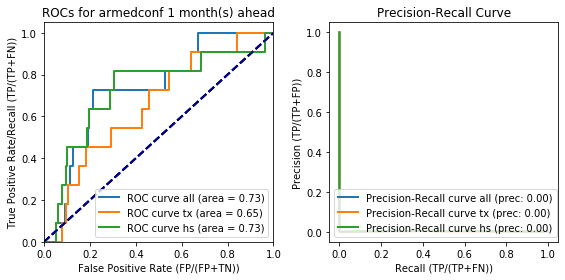

- - - - -- - - - - - - - - - - - - - - - - - - - - - 
TARGET: armedconf f3
Model: all
ROC: 0.687 Precision: 0.008

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      7782
         1.0       0.00      0.00      0.00        31

    accuracy                           1.00      7813
   macro avg       0.50      0.50      0.50      7813
weighted avg       0.99      1.00      0.99      7813

Model: tx
ROC: 0.604 Precision: 0.006

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      7782
         1.0       0.00      0.00      0.00        31

    accuracy                           0.99      7813
   macro avg       0.50      0.50      0.50      7813
weighted avg       0.99      0.99      0.99      7813

Model: hs
ROC: 0.713 Precision: 0.009

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00   

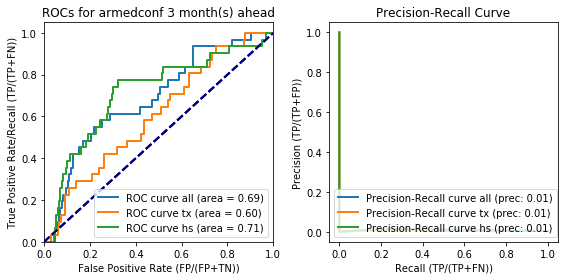

- - - - -- - - - - - - - - - - - - - - - - - - - - - 
TARGET: armedconf f6
Model: all
ROC: 0.701 Precision: 0.017

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      7365
         1.0       0.00      0.00      0.00        60

    accuracy                           0.99      7425
   macro avg       0.50      0.50      0.50      7425
weighted avg       0.98      0.99      0.99      7425

Model: tx
ROC: 0.614 Precision: 0.013

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.98      0.99      7365
         1.0       0.01      0.02      0.01        60

    accuracy                           0.98      7425
   macro avg       0.50      0.50      0.50      7425
weighted avg       0.98      0.98      0.98      7425

Model: hs
ROC: 0.741 Precision: 0.021

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99   

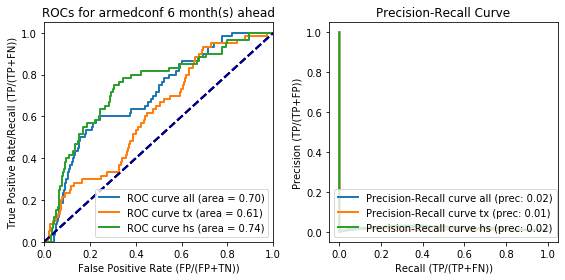

- - - - -- - - - - - - - - - - - - - - - - - - - - - 
TARGET: armedconf f1
Model: all
ROC: 0.668 Precision: 0.002

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      8060
         1.0       0.00      0.00      0.00        11

    accuracy                           1.00      8071
   macro avg       0.50      0.50      0.50      8071
weighted avg       1.00      1.00      1.00      8071

Model: tx
ROC: 0.663 Precision: 0.002

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      8060
         1.0       0.00      0.00      0.00        11

    accuracy                           1.00      8071
   macro avg       0.50      0.50      0.50      8071
weighted avg       1.00      1.00      1.00      8071

Model: hs
ROC: 0.713 Precision: 0.004

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00   

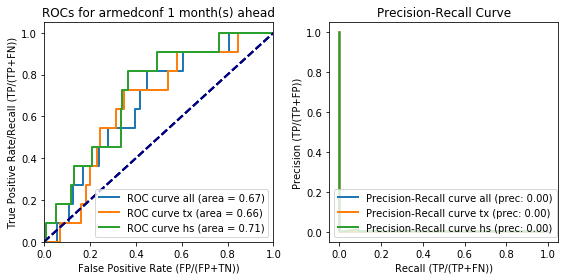

- - - - -- - - - - - - - - - - - - - - - - - - - - - 
TARGET: armedconf f3
Model: all
ROC: 0.627 Precision: 0.007

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      7782
         1.0       0.00      0.00      0.00        31

    accuracy                           1.00      7813
   macro avg       0.50      0.50      0.50      7813
weighted avg       0.99      1.00      0.99      7813

Model: tx
ROC: 0.648 Precision: 0.008

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      7782
         1.0       0.00      0.00      0.00        31

    accuracy                           1.00      7813
   macro avg       0.50      0.50      0.50      7813
weighted avg       0.99      1.00      0.99      7813

Model: hs
ROC: 0.651 Precision: 0.009

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00   

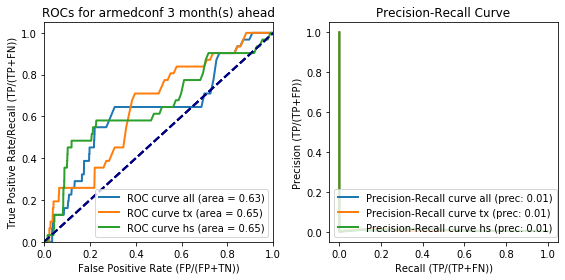

- - - - -- - - - - - - - - - - - - - - - - - - - - - 
TARGET: armedconf f6
Model: all
ROC: 0.61 Precision: 0.013

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      7365
         1.0       0.00      0.00      0.00        60

    accuracy                           0.99      7425
   macro avg       0.50      0.50      0.50      7425
weighted avg       0.98      0.99      0.99      7425

Model: tx
ROC: 0.592 Precision: 0.02

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      7365
         1.0       0.00      0.00      0.00        60

    accuracy                           0.99      7425
   macro avg       0.50      0.50      0.50      7425
weighted avg       0.98      0.99      0.99      7425

Model: hs
ROC: 0.655 Precision: 0.015

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99     

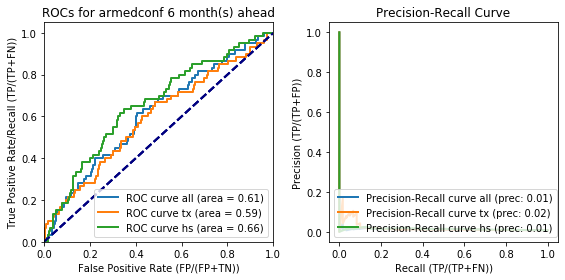

- - - - -- - - - - - - - - - - - - - - - - - - - - - 
TARGET: escalation f1
Model: all
ROC: 0.903 Precision: 0.265

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.98      0.99      7942
         1.0       0.30      0.45      0.36       129

    accuracy                           0.97      8071
   macro avg       0.64      0.72      0.67      8071
weighted avg       0.98      0.97      0.98      8071

Model: tx
ROC: 0.895 Precision: 0.242

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      7942
         1.0       0.31      0.41      0.35       129

    accuracy                           0.98      8071
   macro avg       0.65      0.70      0.67      8071
weighted avg       0.98      0.98      0.98      8071

Model: hs
ROC: 0.908 Precision: 0.277

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99  

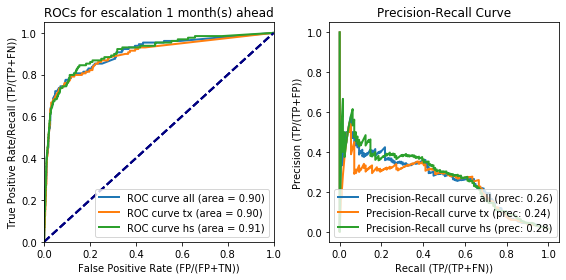

- - - - -- - - - - - - - - - - - - - - - - - - - - - 
TARGET: escalation f3
Model: all
ROC: 0.917 Precision: 0.525

Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      7504
         1.0       0.59      0.61      0.60       309

    accuracy                           0.97      7813
   macro avg       0.79      0.80      0.79      7813
weighted avg       0.97      0.97      0.97      7813

Model: tx
ROC: 0.899 Precision: 0.53

Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.99      0.98      7504
         1.0       0.63      0.60      0.61       309

    accuracy                           0.97      7813
   macro avg       0.81      0.79      0.80      7813
weighted avg       0.97      0.97      0.97      7813

Model: hs
ROC: 0.916 Precision: 0.512

Classification Report:
               precision    recall  f1-score   support

         0.0       0.98   

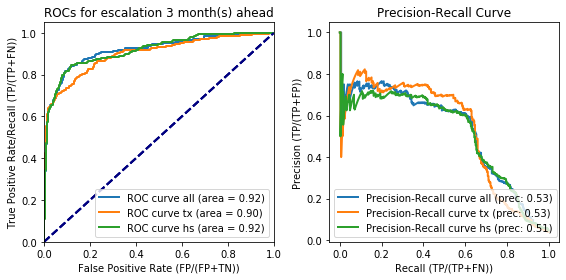

- - - - -- - - - - - - - - - - - - - - - - - - - - - 
TARGET: escalation f6
Model: all
ROC: 0.9 Precision: 0.63

Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.98      0.98      6975
         1.0       0.63      0.60      0.61       450

    accuracy                           0.95      7425
   macro avg       0.80      0.79      0.79      7425
weighted avg       0.95      0.95      0.95      7425

Model: tx
ROC: 0.859 Precision: 0.585

Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.95      0.96      6975
         1.0       0.44      0.59      0.50       450

    accuracy                           0.93      7425
   macro avg       0.71      0.77      0.73      7425
weighted avg       0.94      0.93      0.93      7425

Model: hs
ROC: 0.896 Precision: 0.615

Classification Report:
               precision    recall  f1-score   support

         0.0       0.98     

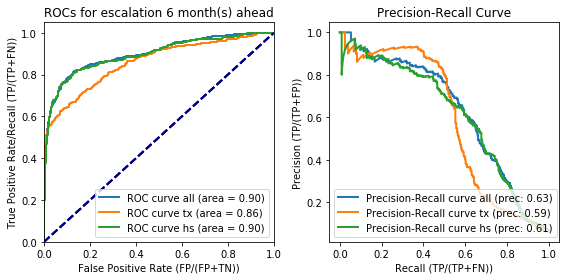

- - - - -- - - - - - - - - - - - - - - - - - - - - - 
TARGET: escalation f1
Model: all
ROC: 0.901 Precision: 0.273

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      7942
         1.0       0.50      0.12      0.20       129

    accuracy                           0.98      8071
   macro avg       0.74      0.56      0.60      8071
weighted avg       0.98      0.98      0.98      8071

Model: tx
ROC: 0.901 Precision: 0.209

Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      7942
         1.0       0.29      0.05      0.08       129

    accuracy                           0.98      8071
   macro avg       0.64      0.52      0.54      8071
weighted avg       0.97      0.98      0.98      8071

Model: hs
ROC: 0.906 Precision: 0.225

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99  

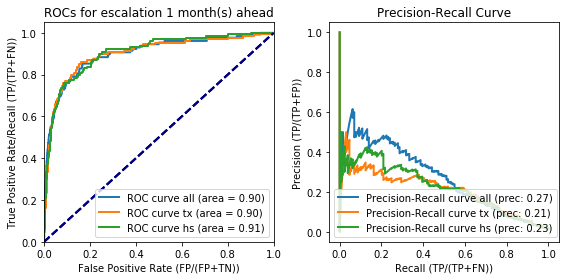

- - - - -- - - - - - - - - - - - - - - - - - - - - - 
TARGET: escalation f3
Model: all
ROC: 0.909 Precision: 0.491

Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      7504
         1.0       0.65      0.35      0.46       309

    accuracy                           0.97      7813
   macro avg       0.81      0.67      0.72      7813
weighted avg       0.96      0.97      0.96      7813

Model: tx
ROC: 0.904 Precision: 0.494

Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.99      0.98      7504
         1.0       0.70      0.43      0.53       309

    accuracy                           0.97      7813
   macro avg       0.84      0.71      0.76      7813
weighted avg       0.97      0.97      0.97      7813

Model: hs
ROC: 0.899 Precision: 0.482

Classification Report:
               precision    recall  f1-score   support

         0.0       0.97  

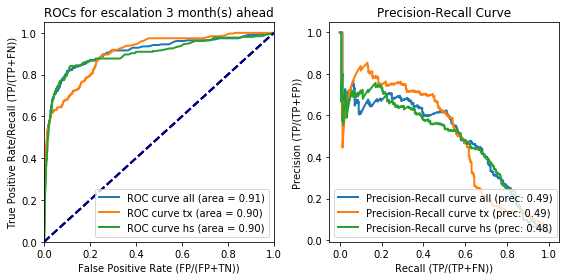

- - - - -- - - - - - - - - - - - - - - - - - - - - - 
TARGET: escalation f6
Model: all
ROC: 0.888 Precision: 0.629

Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      6975
         1.0       0.80      0.48      0.60       450

    accuracy                           0.96      7425
   macro avg       0.88      0.74      0.79      7425
weighted avg       0.96      0.96      0.96      7425

Model: tx
ROC: 0.883 Precision: 0.653

Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      1.00      0.98      6975
         1.0       0.88      0.50      0.64       450

    accuracy                           0.97      7425
   macro avg       0.92      0.75      0.81      7425
weighted avg       0.96      0.97      0.96      7425

Model: hs
ROC: 0.9 Precision: 0.601

Classification Report:
               precision    recall  f1-score   support

         0.0       0.97    

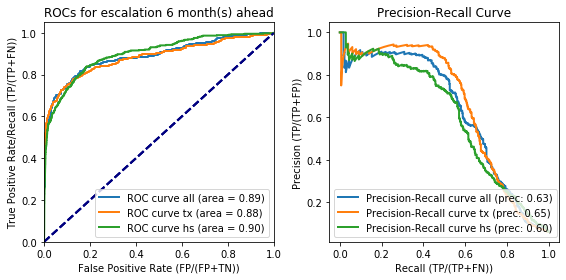

- - - - -- - - - - - - - - - - - - - - - - - - - - - 


In [84]:
for algo in algos:
    for target in ['armedconf']:
        for sft in [1,3,6]: #,2]:
            print('TARGET:', target, f'f{sft}') #, model)
            get_roc_pr(df, sft, target, ['all', 'tx', 'hs'], start_month_year, algo = algo)
            print('- - - - -- - - - - - - - - - - - - - - - - - - - - - ')

for algo in algos:
    for target in ['escalation']:
        for sft in [1,3,6]: #,2]:
            print('TARGET:', target, f'f{sft}') #, model)
            get_roc_pr(df, sft, target, ['all', 'tx', 'hs'], start_month_year, algo = algo)
            print('- - - - -- - - - - - - - - - - - - - - - - - - - - - ')

## Separation Plots (for classification)

Could be adapted for months since.

In [55]:
def separation_plot(pdata, fname, alpha=1):
    '''
    Display observed events against predicted probabilities for binary classification problems
    Arguments
    ---------
        y : vector of observed class labels
        yhat : vector of predicted probabilities
        fname: file path to directory to save plot 
        alpha: float from 0 to 1, transparency of indicators of observed events
    '''

    pdata.columns = ['y', 'yhat']
    pdata = pdata.sort_values('yhat')
    pdata = pdata.reset_index(drop=True)

    events = pdata[pdata['y'] == 1]
    evals = events.index.values

    fig = plt.figure(figsize=(20, 5))
    plt.ylabel('Predicted risk')
    ax = plt.gca()
    ax.set_xlim([1, (evals[-1] + 1)])
    ax.set_ylim([0, 1])
    
    rr = 0
    for i in evals:
        if rr == 0:
            ax.axvline(x=i, linewidth=0.2, linestyle='-', color='k', alpha=alpha, label = 'Increases', zorder=2)
            rr = 1
        else:
            ax.axvline(x=i, linewidth=0.2, linestyle='-', color='k', alpha=alpha, zorder=1)
    
    ax.plot(pdata['yhat'], linestyle='--', color='red', lw = 4, label = 'Predicted increase', zorder=3)
    ax.set_xlabel('Rank of prediction')
    ax.legend(loc="upper left")
    #plt.savefig(fname)
    plt.show()
    #fig.savefig(f'sep_plot_{target}_{algo}_f{forward}.png')
    plt.close() 

In [56]:
#monthsince as the key sufficient statistic - make sure you understand

def produce_stats(df, true_vals, pred_vals): #monthsince

    #drop any rows for which there are no predictions
    restricted=df.dropna(subset=[true_vals,f'{pred_vals}_all', f'{pred_vals}_hs', f'{pred_vals}_tx'])
    
    # IGNORED
    #only keep observations where there has been at least (0) months of peace
    #restricted=restricted[restricted["anyviolence_dp"]>=monthsince] #anyviolence_dp counts months of peace duration
    
    y_true=restricted[true_vals]

    # full model
    #y_scores=restricted[f'{pred_vals}_all']
    #print("observations:", len(y_scores))
    #print("full model AUC:", roc_auc_score(y_true.astype('int'), restricted[f'{pred_vals}_all']), "and av.precision:", average_precision_score(y_true.astype('int'), y_scores))

    # history model
    #y_scores=restricted[f'{pred_vals}_hs']
    #print("history model AUC:", roc_auc_score(y_true.astype('int'), restricted[f'{pred_vals}_hs']), "and av.precision:", average_precision_score(y_true.astype('int'), y_scores))

    # text model
    #y_scores=restricted[f'{pred_vals}_tx']
    #print("text model AUC:", roc_auc_score(y_true.astype('int'), restricted[f'{pred_vals}_tx']), "and av.precision:", average_precision_score(y_true.astype('int'), y_scores))

    # Print separation plots
    print("")

    print('Full model separation plot:')
    sep_data=restricted[[true_vals,f'{pred_vals}_all']]
    #name=Path(spitout + "{}_separation_plot.pdf".format(model_fitted))
    separation_plot(sep_data, 'name')

    print('History model separation plot:')
    sep_data=restricted[[true_vals,f'{pred_vals}_hs']]
    #name=Path(spitout + "{}_separation_plot.pdf".format(model_fitted))
    separation_plot(sep_data, 'name')

    print('Text model separation plot:')
    sep_data=restricted[[true_vals,f'{pred_vals}_tx']]
    #name=Path(spitout + "{}_separation_plot.pdf".format(model_fitted))
    separation_plot(sep_data, 'name')
    

-----------------------------------------------------------------------------------------
STATISTICS FOR TAGRET armedconf, predicting 1 month(s) ahead

Full model separation plot:


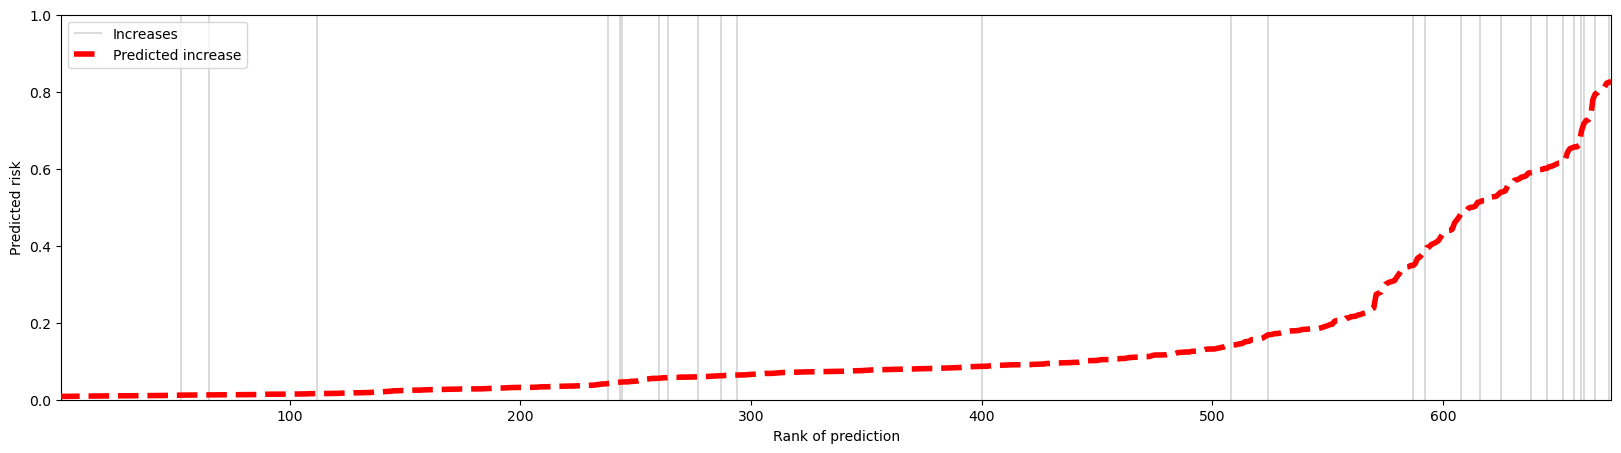

History model separation plot:


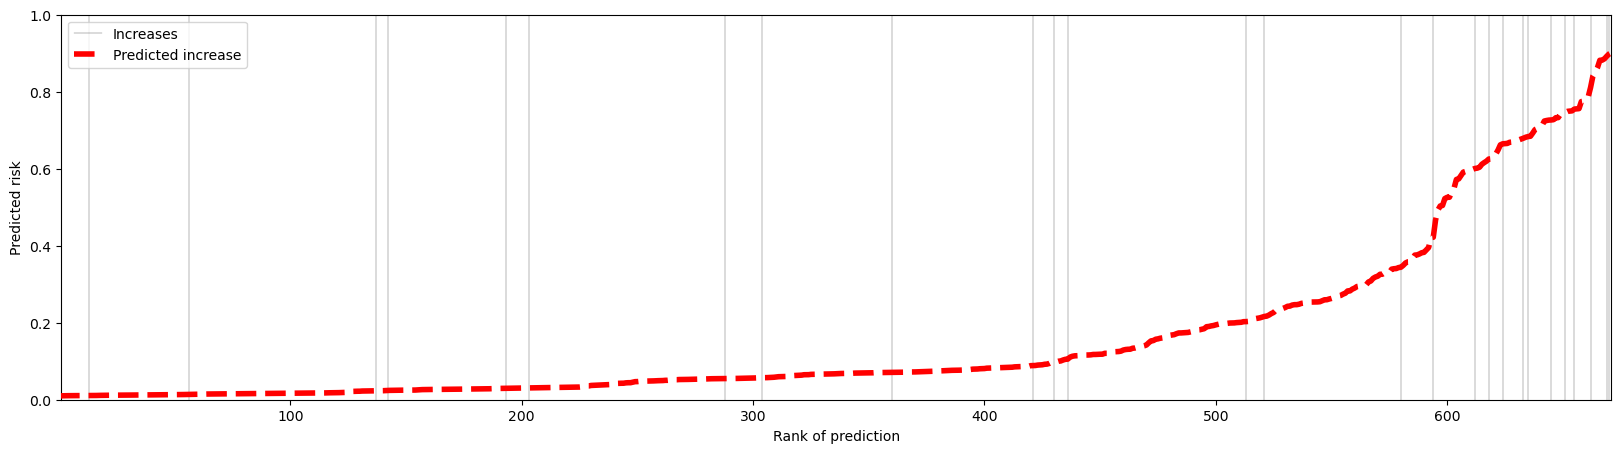

Text model separation plot:


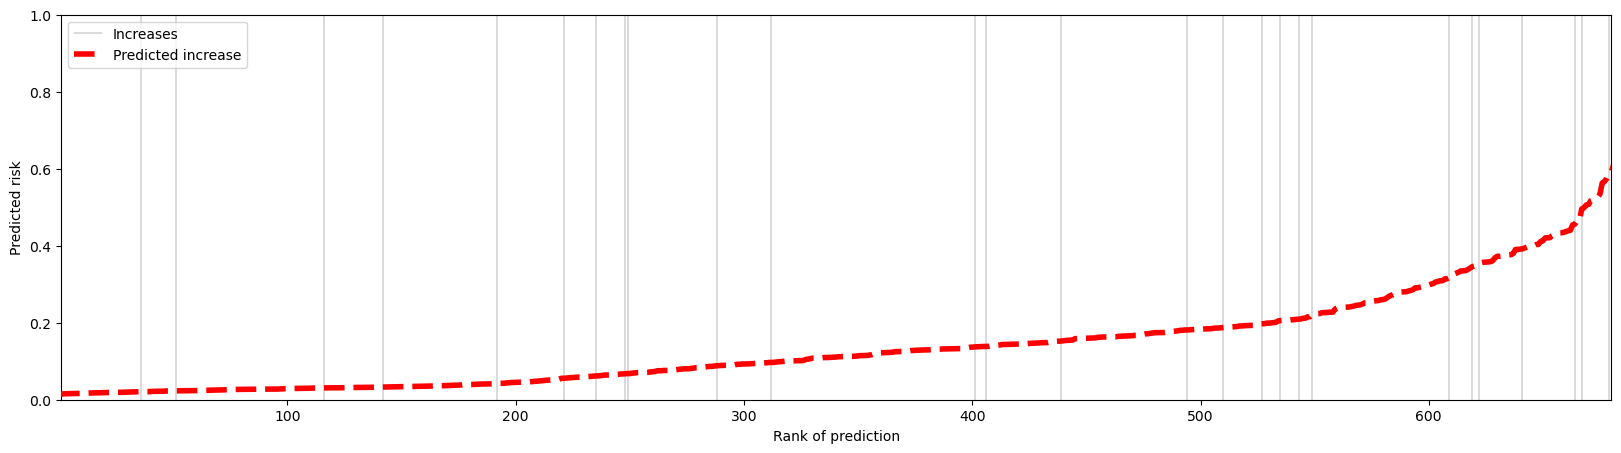

In [156]:
plot_targtes = ['armedconf']
plot_ffwds = [1]

algo = 'rf'
for target in plot_targtes:
    for forward in plot_ffwds:
        print('-----------------------------------------------------------------------------------------')
        print(f'STATISTICS FOR TAGRET {target}, predicting {forward} month(s) ahead')
        produce_stats(df, f'{target}_f{forward}', f'pred_{target}_{algo}_f{forward}')

## Root mean squared error (for regression)

In [157]:
fwds = [1,3,6]
models = ['all', 'hs', 'tx']

start_date = start_month_year #start_date ##start_date = dt.datetime(2018, 1, 2)

errors = {}

for algo in algos: 
    print('ALGORITHM:', algo)
    
    for model in models:

        for fwd in fwds:
                
                # get_tar_pred(df: pd.DataFrame() , fwd: int, model: str, start_time: dt, target: str, algo: str):
                y_trues, y_preds = get_tar_pred(df, fwd, model, start_date, target_regr, algo)
            
                errors[f'{model}_{fwd}'] = mean_squared_error(y_trues, y_preds)

    print('All Root Mean Squared Errors:')
    print(pd.Series(errors)) #.sort_values()

ALGORITHM: rf
All Root Mean Squared Errors:
all_1    0.035372
all_3    0.012796
all_6    0.006631
hs_1     0.035483
hs_3     0.014417
hs_6     0.008106
tx_1     0.031391
tx_3     0.010843
tx_6     0.005765
dtype: float64
ALGORITHM: xgb
All Root Mean Squared Errors:
all_1    0.046252
all_3    0.014833
all_6    0.036265
hs_1     0.038762
hs_3     0.013923
hs_6     0.035882
tx_1     0.034117
tx_3     0.013179
tx_6     0.033106
dtype: float64


## Plots by country for inspection

In [158]:
# pick country, forecast horizon and model
country = 'LKA'
#'SSD', BFA, LKA (srilanka), MMR (myanmar), IRQ (iraq), ETH (ethiopia), COD (congo), AFG (afghanistan), SOM (somalia), SYR (syria), UKR (ukraine), YEM (yemen), VEN (venezuela), ZWE (zimbabwe), VNM (vietnam), TUR (turkey), SDN (sudan), PAK (pakistan), NGA (nigeria), MEX (mexico), LBY (libya), IND (india), IDN (indonesia), EGY (egypt), COL (colombia), CAF (central african republic), BDI (burundi), BGD (bangladesh), BOL (bolivia), CMR (cameroon), CIV (cote d'ivoire), DZA (algeria), ECU (ecuador), GIN (guinea), HTI (haiti), KEN (kenya), LBN (lebanon), MDG (madagascar), MLI (mali), MOZ (mozambique), NER (niger), PHL (philippines), PRY (paraguay), RWA (rwanda), SLE (sierra leone), TCD (chad), TGO (togo), TUN (tunisia), UGA (uganda), ZMB (zambia), ZAF (south africa), TZA (tanzania), THA (thailand), SWE (sweden), NOR (norway), NLD (netherlands), MYS (malaysia), LUX (luxembourg), KOR (south korea), JPN (japan), ITA (italy), IRL (ireland), ISL (iceland), HUN (hungary), GRC (greece), GBR (united kingdom), FRA (france), FIN (finland), ESP (spain), DNK (denmark), DEU (germany), CZE (czech republic), CAN (canada), BEL (belgium), AUT (austria), AUS (australia), ARG (argentina), USA (united states), CHE (switzerland), CHL (chile), BRA (brazil), POL (poland), PRT (portugal), NZL (new zealand), MEX (
forward = 1

# get country df
country_name = pc.countries.get(alpha_3=country)
country_clsf =  df[df.isocode == country]

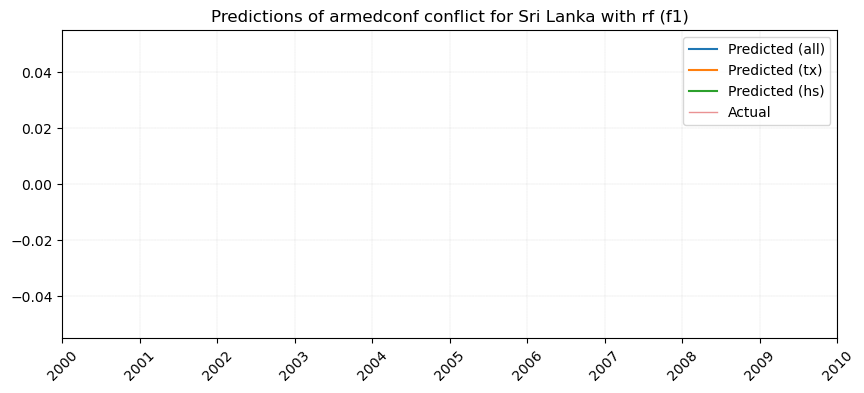

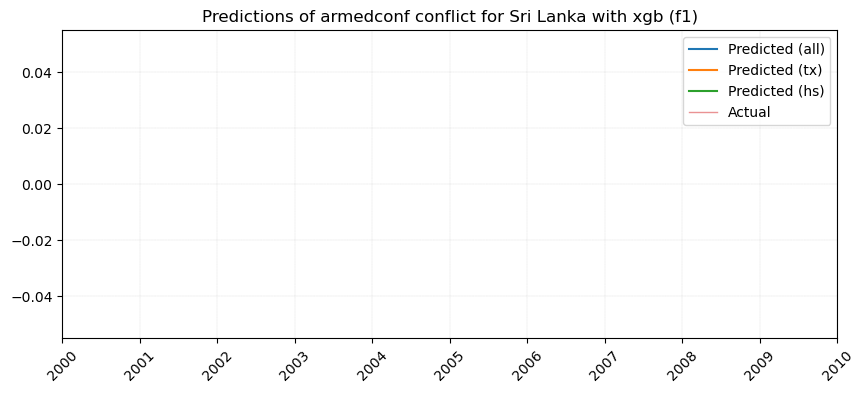

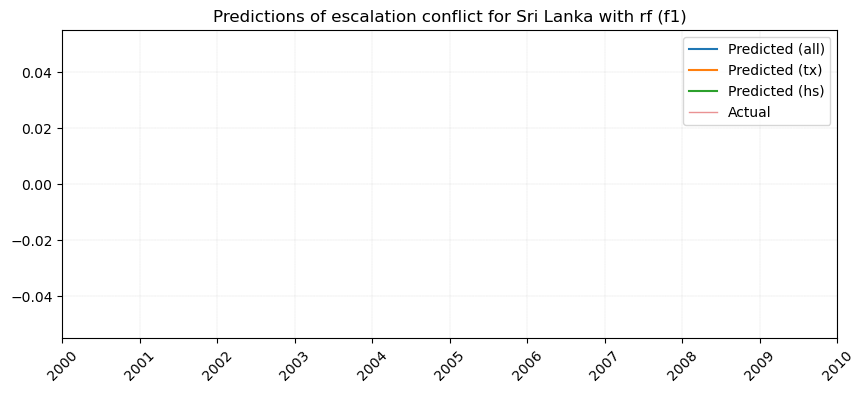

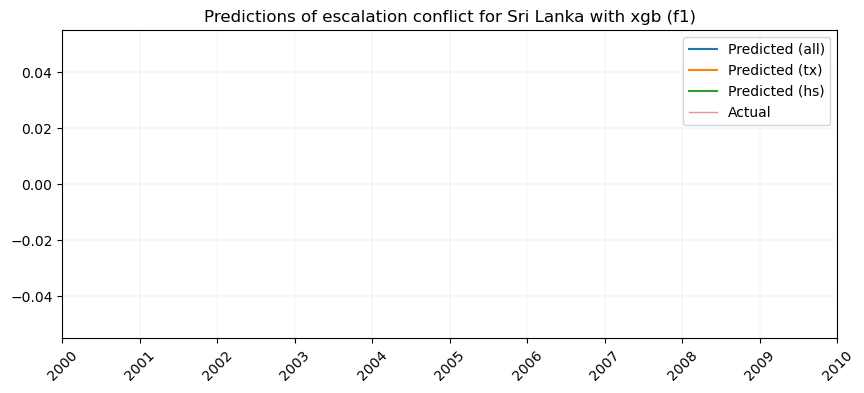

In [159]:
# plots for classification targets
for target in clsf_targets:
    for algo in algos:
        fig = plt.figure(figsize=(10,4)) 

        for model in ['all', 'tx', 'hs']:
            plt.plot(country_clsf.month_year,country_clsf[f'pred_{target}_{algo}_f{forward}_{model}'], label = f'Predicted ({model})')

        plt.plot(country_clsf.month_year,country_clsf[f'{target}_f{forward}'], linewidth=1, label = 'Actual', alpha=0.5)
        
        plt.title(f'Predictions of {target} conflict for {country_name.name} with {algo} (f{forward})')
        plt.legend()
        
        plt.grid(color='grey', linestyle='--', linewidth=0.1)
        plt.xticks(rotation=45)
        plt.show()

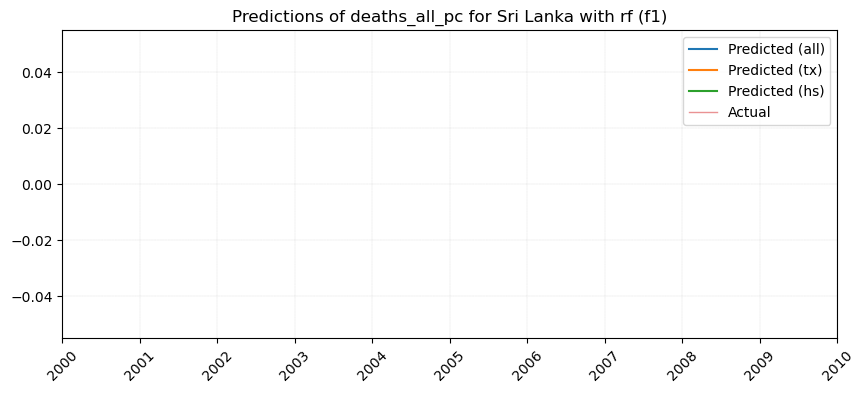

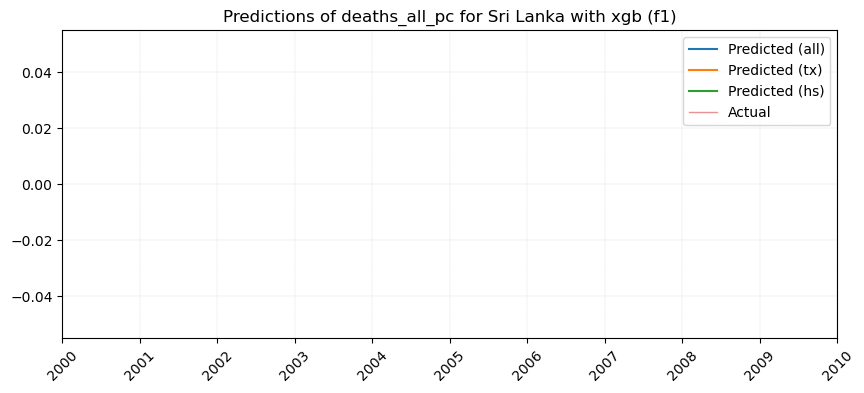

In [160]:
# plots for regression targets

for algo in algos:
    plt.figure(figsize=(10,4))


    for model in ['all', 'tx', 'hs']:
        plt.plot(country_clsf.month_year,country_clsf[f'pred_{target_regr}_{algo}_f{forward}_{model}'], label = f'Predicted ({model})')

    plt.plot(country_clsf.month_year,country_clsf[f'{target_regr}_f{forward}'], linewidth=1, label = 'Actual', alpha=0.5)

    plt.title(f'Predictions of {target_regr} for {country_name.name} with {algo} (f{forward})')
    plt.legend()
    plt.grid(color='grey', linestyle='--', linewidth=0.1)
    plt.xticks(rotation=45)
    plt.show()

## Metrics for Naive Baseline Model
This model simply predicts that the future month(s) will be like the current month.

### Data prep
The difficulty was that in order to compare like with like, we needed to ensure that for the evaluation of the f3 and f6 models, the final 3 and 6 rows are dropped. In the original code, the make_target function generate NaN values, for which the rows are dropped. Here we need to 'artificially' drop the correct number of rows. In order to match the logic of our existing functions we also generate the different 'f1' etc names (and put an 'n' for the algorithm) even though the values are always the same.

In [161]:
# create naive predctions 1 month ahead
df_nv1 = df.copy()
forward = [1]
for i in forward:
    df_nv1[f'pred_{target_conf}_n_f{i}_nv'] = df_nv1.groupby(unit_of_analyis)[target_conf].shift(i)
    df_nv1[f'pred_{target_escl}_n_f{i}_nv'] = df_nv1.groupby(unit_of_analyis)[target_escl].shift(i)
    df_nv1[f'pred_{target_regr}_n_f{i}_nv'] = df_nv1.groupby(unit_of_analyis)[target_regr].shift(i) 
    # drop the final month for each country (the attempt to fill them with NaN did not work)
    df_nv1 = df_nv1.groupby(unit_of_analyis).apply(lambda x: x.iloc[:-(i)])
     #df_nv1[f'pred_{target_regr}__f{i}_nv'] = df_nv1.groupby(unit_of_analyis)[f'pred_{target_regr}__f{i}_nv'].transform(lambda x: x if x.name != x.index[-i] else np.nan)
df_nv1.reset_index(drop=True, inplace=True)


# create naive predctions 3 months ahead (using the 1 month ahead predictions)
df_nv2 = df_nv1.copy()
forward = [3]
for i in forward:
    df_nv2[f'pred_{target_conf}_n_f{i}_nv'] = df_nv2[f'pred_{target_conf}_n_f1_nv']
    df_nv2[f'pred_{target_escl}_n_f{i}_nv'] = df_nv2[f'pred_{target_escl}_n_f1_nv']
    df_nv2[f'pred_{target_regr}_n_f{i}_nv'] = df_nv2[f'pred_{target_regr}_n_f1_nv']   
    df_nv2 = df_nv2.groupby(unit_of_analyis).apply(lambda x: x.iloc[:-(i-1)]) # don't drop three rows as one already dropped above
df_nv2.reset_index(drop=True, inplace=True)

# create naive predctions 6 months ahead (using the 1 month ahead predictions)
df_nv_all = df_nv2.copy()
forward = [6]
for i in forward:
    df_nv_all[f'pred_{target_conf}_n_f{i}_nv'] = df_nv_all[f'pred_{target_conf}_n_f1_nv']
    df_nv_all[f'pred_{target_escl}_n_f{i}_nv'] = df_nv_all[f'pred_{target_escl}_n_f1_nv']
    df_nv_all[f'pred_{target_regr}_n_f{i}_nv'] = df_nv_all[f'pred_{target_regr}_n_f1_nv']
    df_nv_all = df_nv_all.groupby(unit_of_analyis).apply(lambda x: x.iloc[:-(i-3)]) # don't drop six rows as three already dropped above
df_nv_all.reset_index(drop=True, inplace=True)

In [162]:
# check if right columns were dropped

#df_nv1.loc[df_nv1['isocode'] == 'AFG', ['isocode', 'month_year','pred_armedconf_n_f1_nv']][-4:]
df_nv2.loc[df_nv2['isocode'] == 'AFG', ['isocode', 'month_year','pred_armedconf_n_f3_nv']][-4:]
#df_nv_all.loc[df_nv_all['isocode'] == 'AFG', ['isocode', 'month_year','pred_armedconf__f6_nv']]#[-4:]

,isocode,month_year,pred_armedconf_n_f3_nv


### ROC and precision re-call curves (for classification baseline)

Model: nv
ROC: 0.558 Precision: 0.058

Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.97      0.97       644
         1.0       0.16      0.15      0.15        27

    accuracy                           0.93       671
   macro avg       0.56      0.56      0.56       671
weighted avg       0.93      0.93      0.93       671



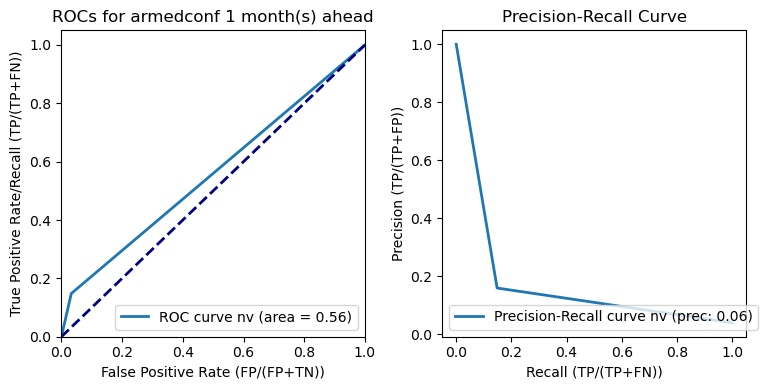

- - - - -- - - - - - - - - - - - - - - - - - - - - - 
Model: nv
ROC: 0.55 Precision: 0.14

Classification Report:
               precision    recall  f1-score   support

         0.0       0.90      0.97      0.94       579
         1.0       0.36      0.13      0.19        70

    accuracy                           0.88       649
   macro avg       0.63      0.55      0.56       649
weighted avg       0.84      0.88      0.86       649



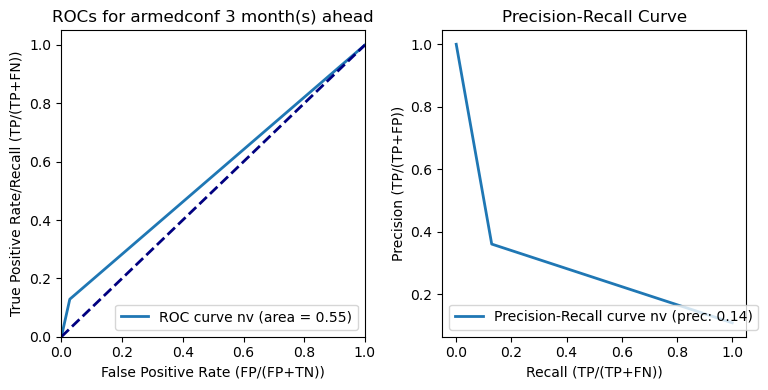

- - - - -- - - - - - - - - - - - - - - - - - - - - - 
Model: nv
ROC: 0.535 Precision: 0.214

Classification Report:
               precision    recall  f1-score   support

         0.0       0.83      0.98      0.90       503
         1.0       0.53      0.09      0.15       113

    accuracy                           0.82       616
   macro avg       0.68      0.54      0.52       616
weighted avg       0.77      0.82      0.76       616



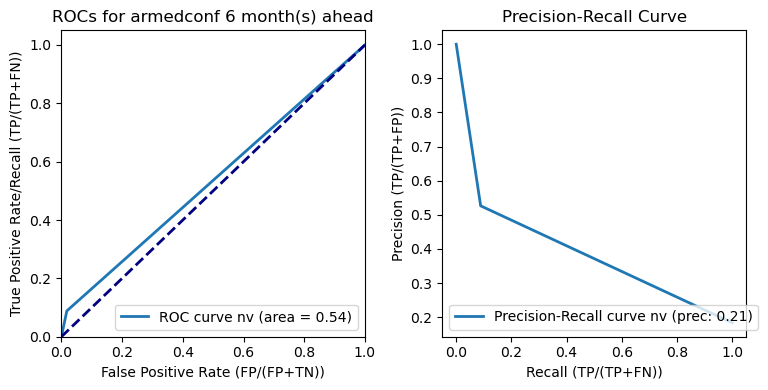

- - - - -- - - - - - - - - - - - - - - - - - - - - - 
Model: nv
ROC: 0.551 Precision: 0.096

Classification Report:
               precision    recall  f1-score   support

         0.0       0.93      0.93      0.93       618
         1.0       0.18      0.17      0.17        53

    accuracy                           0.87       671
   macro avg       0.55      0.55      0.55       671
weighted avg       0.87      0.87      0.87       671



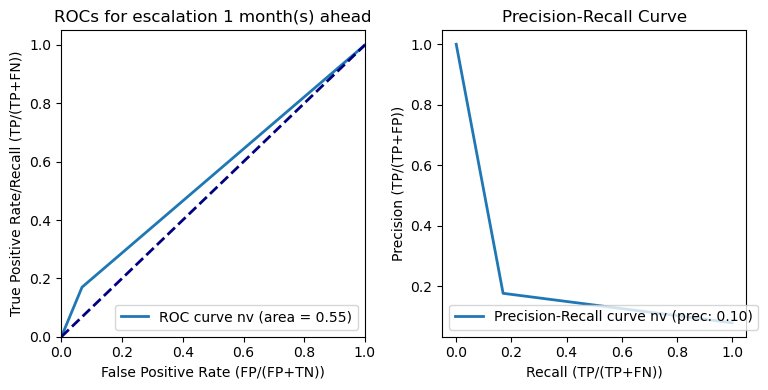

- - - - -- - - - - - - - - - - - - - - - - - - - - - 
Model: nv
ROC: 0.551 Precision: 0.235

Classification Report:
               precision    recall  f1-score   support

         0.0       0.82      0.94      0.87       518
         1.0       0.41      0.16      0.23       131

    accuracy                           0.78       649
   macro avg       0.61      0.55      0.55       649
weighted avg       0.73      0.78      0.74       649



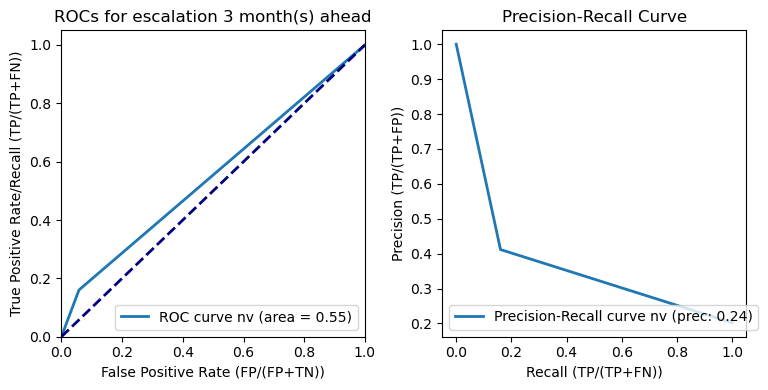

- - - - -- - - - - - - - - - - - - - - - - - - - - - 
Model: nv
ROC: 0.544 Precision: 0.362

Classification Report:
               precision    recall  f1-score   support

         0.0       0.69      0.96      0.81       415
         1.0       0.60      0.13      0.21       201

    accuracy                           0.69       616
   macro avg       0.65      0.54      0.51       616
weighted avg       0.67      0.69      0.61       616



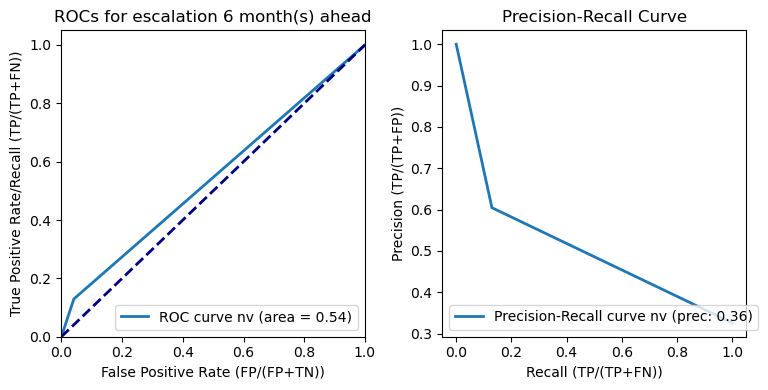

- - - - -- - - - - - - - - - - - - - - - - - - - - - 


In [163]:
#get_tar_pred(df_nv, 1, model: 'nv', start_time: dt, target: str, type: str):

#get_roc_pr(df_og = df_nv, fwd = 1, target: str, models: list, staryearid, binary=True, plot=True):

fwds = [1,3,6]

for target in ['armedconf', 'escalation']:
    for sft in fwds:
        #print(target, f'f_{sft}') #, model)
        # et_roc_pr(df, sft, target, ['all', 'tx', 'hs'], start_month_year, algo = algo)
        if sft == 1:
            get_roc_pr(df_nv1, sft, target, ['nv'], start_month_year, algo= 'n')
            
        elif sft == 3:
            get_roc_pr(df_nv2, sft, target, ['nv'], start_month_year, algo= 'n')
        elif sft == 6:
            get_roc_pr(df_nv_all, sft, target, ['nv'], start_month_year, algo= 'n')

        print('- - - - -- - - - - - - - - - - - - - - - - - - - - - ')

### Root mean squared error (for regression baseline)

In [164]:
errors = {}
for fwd in fwds:
#    for model in models:
            
            y_trues, y_preds = get_tar_pred(df_nv_all, fwd, 'nv', start_month_year, target_regr, 'n')
        
            errors[f'nv_{fwd}'] = mean_squared_error(y_trues, y_preds)

print('All Root Mean Squared Errors:')
print(pd.Series(errors)) #.sort_values()

All Root Mean Squared Errors:
nv_1    0.055234
nv_3    0.037249
nv_6    0.032330
dtype: float64
